<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SVIBDN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [2]:
!unzip -qq images.zip

In [4]:
!unzip -qq labels.zip

In [5]:
from PIL import Image
from numpy import *
train = []
class_label=[]
label = []
files = glob.glob ("images/*.jpg")
for myFile in files:
    class_label.append(float(myFile[7]))
    image = array(Image.open(myFile))
    image_name=os.path.split(myFile)[1]
    label_image = array(Image.open('labels/'+image_name))
    label.append (label_image)
    train.append (image)
train = np.array(train)
label = np.array(label)
class_label=np.array(class_label) 
label= np.reshape(label,[train.shape[0],label.shape[1],label.shape[2],label.shape[3]])
train= np.reshape(train,[train.shape[0],train.shape[1],train.shape[2],train.shape[3]])
np.save('class_labels', class_label)
np.save('total-images',train)
np.save('label-images',label)

In [2]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [3]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [4]:
def decoder_network(X):
    #x_input = layers.Input(shape=(147))
    #x = keras.layers.Reshape([7,7,3])(dX)
    x = layers.Conv2DTranspose(2048, (3, 3), strides=2, activation="relu", padding="same")(X)
    x = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=1, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    output = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid", padding="same")(x)
    #model = Model(inputs=X, outputs=output, name='decoder_network')
    return output


In [5]:
def ResNet50():
    #X_input = keras.Input(shape=(224, 224, 3))
    X_input = layers.Input(shape=(224, 224, 3))
    #X = data_augmentation(X_input)
    #X = layers.Rescaling(1./255)(X)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    #7*7*2048
    output1=decoder_network(X)
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    output2 = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    model = Model(inputs=X_input, outputs=[output1,output2] , name='ResNet50')
    #return output1,output2
    return model

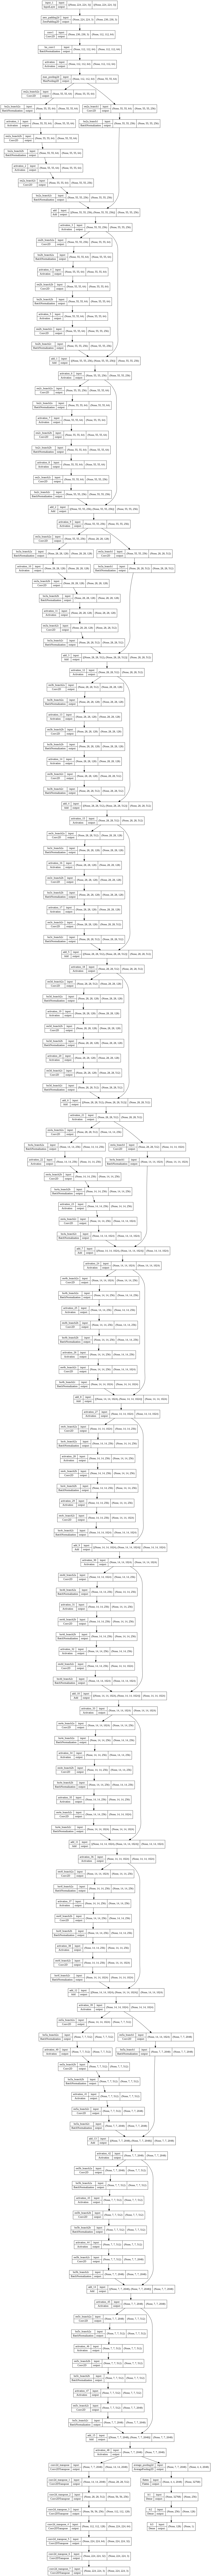

In [6]:
model= ResNet50()
keras.utils.plot_model(model, show_shapes=True)

In [22]:
#model = Model(inputs=X_input, outputs=[output1,output2] , name='ResNet50')
#baseModel=ResNet50()
#baseModel.summary()

In [7]:
loss1=tf.keras.losses.BinaryCrossentropy()
loss2=tf.keras.losses.MeanSquaredError()
model.compile(keras.optimizers.Adam(learning_rate=1e-3),loss = [loss1,loss2]
                        ,
                   metrics=[tf.keras.metrics.BinaryAccuracy()],)


In [8]:
total_images = np.load('total-images.npy')
total_labels = np.load('label-images.npy')
class_labels=np.load('class_labels.npy')

In [114]:
total_images.shape

(12000, 224, 224, 3)

In [115]:
class_labels.shape

(12000,)

In [9]:
#Training Images 
x_train=total_images[:5000]
y_train=total_labels[:5000]
class_label=class_labels[:5000]
x_train = x_train.astype(np.float32)/ 255.0
y_train=y_train.astype(np.float32)/ 255.0
y_train = ( y_train,class_label)

In [89]:
unique, counts = np.unique(class_label, return_counts=True)


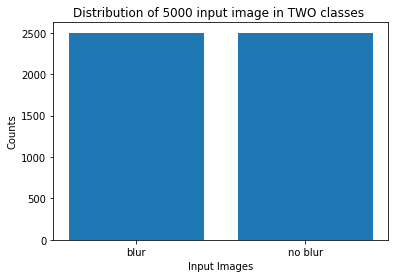

In [91]:
import matplotlib.pyplot as plt  
dataset_classes = ['blur','no blur']
num_images = [counts[0],counts[1]]
plt.bar(dataset_classes, num_images)
plt.title(f"Distribution of {(class_label.shape)[0]} input image in TWO classes ")
plt.xlabel('Input Images')
plt.ylabel('Counts')
plt.show()

In [31]:
unique

array([0., 1.])

In [32]:
counts

array([2499, 2501])

In [10]:
## Optimize
history = model.fit(x_train,[y_train[0],y_train[1]], epochs=5,batch_size=50, validation_split=0.2, shuffle=True)
model.save('new_model.h5')

Epoch 1/5
80/80 [==============================] - 82s 800ms/step - loss: 0.9510 - conv2d_transpose_7_loss: 0.4525 - fc3_loss: 0.4985 - conv2d_transpose_7_binary_accuracy: 0.8516 - fc3_binary_accuracy: 0.4995 - val_loss: 0.8483 - val_conv2d_transpose_7_loss: 0.3443 - val_fc3_loss: 0.5040 - val_conv2d_transpose_7_binary_accuracy: 0.9063 - val_fc3_binary_accuracy: 0.4960
Epoch 2/5
80/80 [==============================] - 62s 772ms/step - loss: 0.8162 - conv2d_transpose_7_loss: 0.3175 - fc3_loss: 0.4988 - conv2d_transpose_7_binary_accuracy: 0.9061 - fc3_binary_accuracy: 0.5013 - val_loss: 0.8070 - val_conv2d_transpose_7_loss: 0.3030 - val_fc3_loss: 0.5040 - val_conv2d_transpose_7_binary_accuracy: 0.9063 - val_fc3_binary_accuracy: 0.4960
Epoch 3/5
80/80 [==============================] - 62s 774ms/step - loss: 0.7979 - conv2d_transpose_7_loss: 0.2991 - fc3_loss: 0.4988 - conv2d_transpose_7_binary_accuracy: 0.9061 - fc3_binary_accuracy: 0.5013 - val_loss: 0.8008 - val_conv2d_transpose_7_los

In [11]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'conv2d_transpose_7_loss', 'fc3_loss', 'conv2d_transpose_7_binary_accuracy', 'fc3_binary_accuracy', 'val_loss', 'val_conv2d_transpose_7_loss', 'val_fc3_loss', 'val_conv2d_transpose_7_binary_accuracy', 'val_fc3_binary_accuracy'])


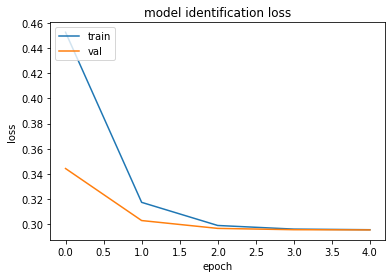

In [13]:
plt.plot(history.history['conv2d_transpose_7_loss'])
plt.plot(history.history['val_conv2d_transpose_7_loss'])
plt.title('model identification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

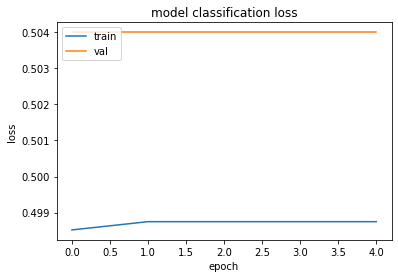

In [14]:
plt.plot(history.history['fc3_loss'])
plt.plot(history.history['val_fc3_loss'])
plt.title('model classification loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

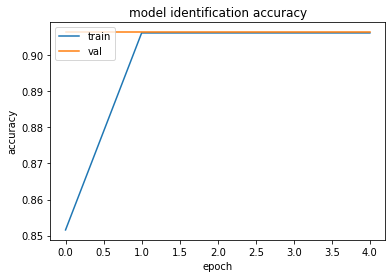

In [15]:
plt.plot(history.history['conv2d_transpose_7_binary_accuracy'])
plt.plot(history.history['val_conv2d_transpose_7_binary_accuracy'])
plt.title('model identification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


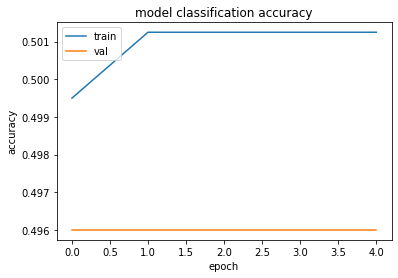

In [16]:
plt.plot(history.history['fc3_binary_accuracy'])
plt.plot(history.history['val_fc3_binary_accuracy'])
plt.title('model classification accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
#evaluation images
eval_images=total_images[8000:10000]
eval_labels=total_labels[8000:10000]
eval_class_label=class_labels[8000:10000]

In [44]:
from keras.models import load_model
from PIL import Image
#images = np.load('test-blurry-images.npy')
images = eval_images[:400]
model = load_model("new_model.h5")
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [82]:
from statistics import mean
mse_classification=[]
mse_blurDetection=[]
for i in range((images.shape)[0]):
  eval_labels[i]=eval_labels[i].astype(np.float32)/ 255.0
  mse_classification.append(((((predictions[i])[1])[0])[0]- eval_class_label[i])**2)
  sb= np. subtract( ((predictions[i])[0])[0], eval_labels[i])
  sq= np. square(sb)
  mseBd = sq.mean()
  mse_blurDetection.append(mseBd)
MSE_C=mean(mse_classification)
MSE_BD=mean(mse_blurDetection)
print(f" MSE for Model Classification: {MSE_C}")
print(f" MSE for Model Blur area detection: {MSE_BD}")

 MSE for Model Classification: 0.5025
 MSE for Model Blur area detection: 0.008056173101067543


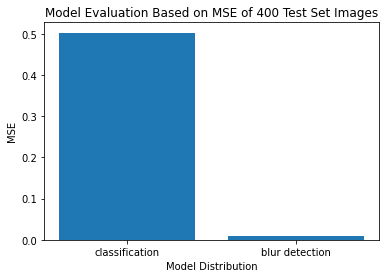

In [86]:
import matplotlib.pyplot as plt  
Model_Distribution = ['classification','blur detection']
Mean_Square_Error = [MSE_C,MSE_BD]
plt.bar(Model_Distribution, Mean_Square_Error)
plt.title(f"Model Evaluation Based on MSE of {(images.shape)[0]} Test Set Images")
plt.xlabel('Model Distribution')
plt.ylabel('MSE')
plt.show()

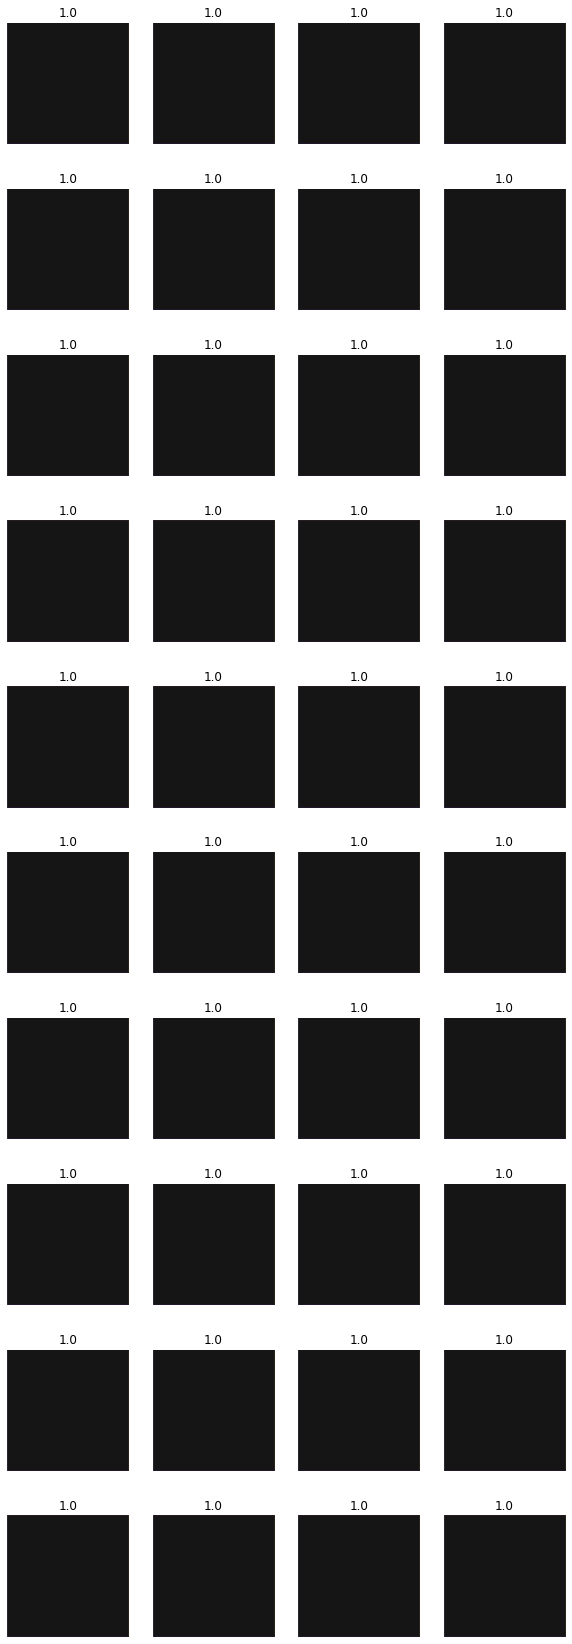

In [87]:
fig = plt.figure(figsize=(10,30))
columns = 4
rows = 10
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(((((predictions[i])[0])[0])*255.0).astype(np.uint8))
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(predicted_class)
  plt.axis("off")
plt.show()

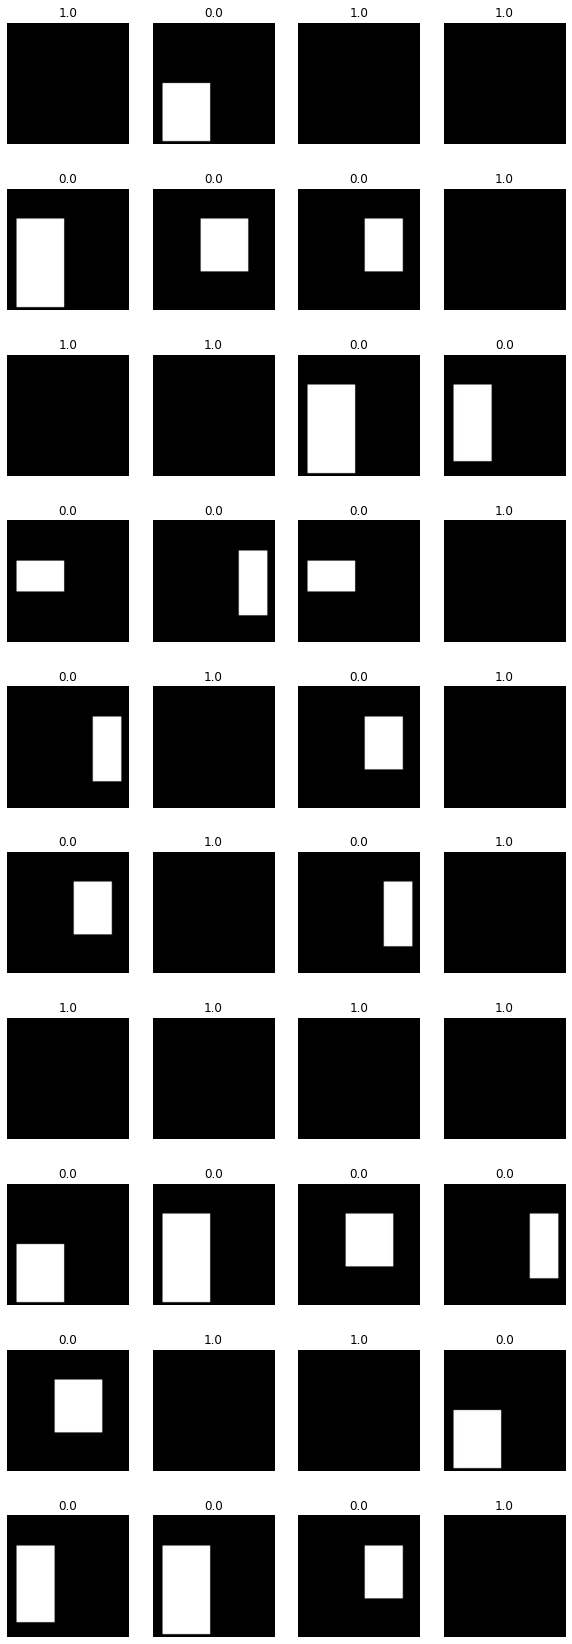

In [23]:
fig = plt.figure(figsize=(10,30))
columns = 4
rows = 10
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(eval_labels[i],cmap='binary')
  plt.title(eval_class_label[i])
  plt.axis("off")
plt.show()

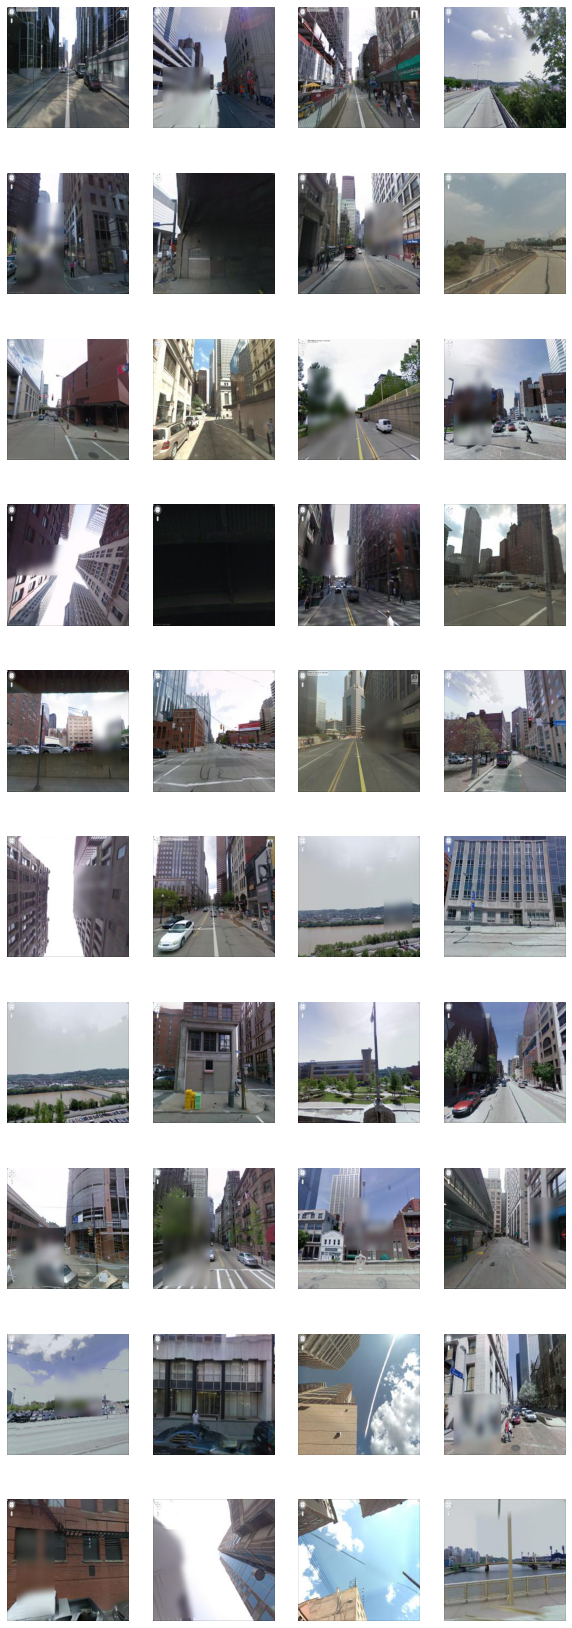

In [52]:
#images = np.load('test-label-images.npy')
#images = images[0:100]
fig = plt.figure(figsize=(10,30))
columns = 4
rows = 10
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i],cmap='binary')
  #plt.title('image')
  plt.axis("off")
plt.show()